Can confirmed cases and fatalities be predicted using health indicators alongside conventional COVID-19 statistics?

This approach involves utilizing around 70 health-related indicators—such as the prevalence of respiratory diseases, hospital density, birth and death rates, and migration data—collected from various countries to predict the number of confirmed COVID-19 cases and deaths.


Assumptions:
Since there is no direct correlation between health indicators—such as cancer rates, respiratory diseases, and similar metrics—and COVID-19 case counts, we expect these features to have lower importance when training the model using XGBoost (Extreme Gradient Boosting).

In contrast, features like the number of confirmed cases in the first 10 or 50 days are likely to carry greater significance and contribute more to the model’s predictive performance than the health indicators.

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

Utility function to compute the Root Mean Squared Logarithmic Error (RMSLE)

In [2]:
def RMSLE(actual: np.ndarray, prediction: np.ndarray) -> float:
    """Calculate RMSLE between actual and predicted values"""
    return np.sqrt(
        np.mean(
            np.power(np.log1p(np.maximum(0, prediction)) - np.log1p(actual), 2)
        )
    )

In [3]:
df = pd.read_csv('train.csv')
df.head(10)
df.shape

(23562, 6)

Preprocessing COVID-19 data by merging location columns, ensuring cumulative counts, extracting day of year, and formatting the date.Preprocessing the data

In [4]:
df = pd.read_csv('train.csv')

df["Country_Region"] = np.where(
    df["Province_State"].isnull(),
    df["Country_Region"],
    df["Country_Region"] + "_" + df["Province_State"],
)

df.drop(columns="Province_State", inplace=True)

if "ConfirmedCases" in df:
    df["ConfirmedCases"] = df.groupby("Country_Region")[
        "ConfirmedCases"
    ].cummax()

if "Fatalities" in df:
    df["Fatalities"] = df.groupby("Country_Region")["Fatalities"].cummax()

if not "DayOfYear" in df:
    df["DayOfYear"] = pd.to_datetime(df["Date"]).dt.dayofyear


df["Date"] = pd.to_datetime(df["Date"]).dt.date


df.shape


(23562, 6)

Loading the health indicators of the countries

In [5]:
country_health_indicators = pd.read_csv('country_health_indicators_v3.csv')
# country_health_indicators.head(10)
country_health_indicators.shape

(180, 70)

Merging the two DataFrames based on the Country_Region column using an inner join.

In [6]:
train = pd.merge(df, country_health_indicators, on="Country_Region", how="left")
train.shape

(23562, 75)

In [7]:
train.head(5)

,Id,Country_Region,Date,ConfirmedCases,Fatalities,DayOfYear,first_1ConfirmedCases,first_1Fatalities,first_10ConfirmedCases,first_50ConfirmedCases,...,total fertility rate,obesity - adult prevalence rate,school_shutdown_1case,school_shutdown_10case,school_shutdown_50case,school_shutdown_1death,FF_DayOfYear,case1_DayOfYear,case10_DayOfYear,case50_DayOfYear
0,1,Afghanistan,2020-01-22,0.0,0.0,22,2020-02-24,2020-03-22,2020-03-14,2020-03-24,...,4.82,5.5,19.0,-0.0,-10.0,-8.0,82.0,55.0,74.0,84.0
1,2,Afghanistan,2020-01-23,0.0,0.0,23,2020-02-24,2020-03-22,2020-03-14,2020-03-24,...,4.82,5.5,19.0,-0.0,-10.0,-8.0,82.0,55.0,74.0,84.0
2,3,Afghanistan,2020-01-24,0.0,0.0,24,2020-02-24,2020-03-22,2020-03-14,2020-03-24,...,4.82,5.5,19.0,-0.0,-10.0,-8.0,82.0,55.0,74.0,84.0
3,4,Afghanistan,2020-01-25,0.0,0.0,25,2020-02-24,2020-03-22,2020-03-14,2020-03-24,...,4.82,5.5,19.0,-0.0,-10.0,-8.0,82.0,55.0,74.0,84.0
4,5,Afghanistan,2020-01-26,0.0,0.0,26,2020-02-24,2020-03-22,2020-03-14,2020-03-24,...,4.82,5.5,19.0,-0.0,-10.0,-8.0,82.0,55.0,74.0,84.0


# XGB Boost Regression

In [8]:
def apply_xgb_model(train, x_columns, y_column, xgb_params):
    X = train[x_columns].to_numpy()
    y = train[y_column].to_numpy()
    xgb_fit = XGBRegressor(**xgb_params).fit(X, y)
    y_hat = xgb_fit.predict(X)
    train[f"yhat_xgb_{y_column}"] = y_hat
    return RMSLE(y, y_hat), xgb_fit

we have used the following columns of the training dataset for the training. 

In [9]:
xgb_params = dict(
    gamma=0.2,
    learning_rate=0.15,
    n_estimators=100,
    max_depth=11,
    min_child_weight=1,
    nthread=8,
    objective="reg:squarederror")

x_columns= list(set(train.columns) - {'ConfirmedCases','Country_Region','Date','Fatalities','Id','first_100ConfirmedCases','first_10ConfirmedCases','first_1ConfirmedCases','first_1Fatalities','first_50ConfirmedCases','school_closure','yhat_xgb_ConfirmedCases','yhat_xgb_Fatalities'})



xgb_c_rmsle, xgb_c_fit = apply_xgb_model(
    train, x_columns, "ConfirmedCases", xgb_params)
xgb_f_rmsle, xgb_f_fit = apply_xgb_model(
    train, x_columns, "Fatalities", xgb_params)



# Top boosted features

In [13]:
imps=[]
cols = []
for col, fit in (("ConfirmedCases", xgb_c_fit), ("Fatalities", xgb_f_fit)):
    df = pd.DataFrame(list(zip(x_columns, fit.feature_importances_)), columns=[f"feature_{col}", f"importance_{col}"])
    cols.extend(df.columns.to_list())
    imps.append(df.sort_values(by=f"importance_{col}", ascending=False).to_numpy())
importances = pd.DataFrame(np.hstack(imps), columns=cols, index=range(1, len(imps[0])+1))
importances.sort_values(by="importance_ConfirmedCases",ascending=False)
importances.index.name="rank"
importances.head(20)

,feature_ConfirmedCases,importance_ConfirmedCases,feature_Fatalities,importance_Fatalities
rank,,,,
1,milk_-_excluding_butter,0.198836,HIV/AIDS and tuberculosis (%),0.397034
2,case50_DayOfYear,0.189975,vegetable_oils,0.336348
3,medical_doctors_per10k,0.135768,school_shutdown_50case,0.07189
4,school_shutdown_50case,0.096006,Respiratory diseases (%),0.052994
5,treenuts,0.083553,treenuts,0.041258
6,maternal mortality rate,0.069234,DayOfYear,0.028239
7,population,0.033561,Cancers (%),0.024056
8,spices,0.027326,birth rate,0.010306
9,nbr_surgeons,0.026968,Malaria & neglected tropical diseases (%),0.010111


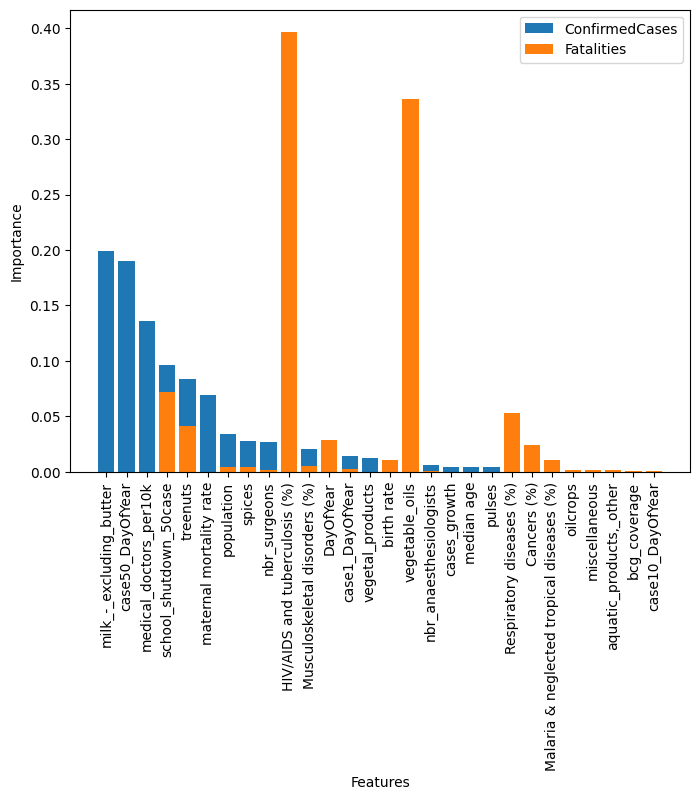

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(importances["feature_ConfirmedCases"][:20], importances["importance_ConfirmedCases"][:20], label="ConfirmedCases")
ax.bar(importances["feature_Fatalities"][:20], importances["importance_Fatalities"][:20], label="Fatalities")
ax.set_xlabel("Features")
ax.set_ylabel("Importance")
ax.legend()

# Rotate the x-axis tick labels to display vertically
plt.xticks(rotation=90)
plt.show()

# Conclusions

The use of COVID-related statistics such as hospital density, case growth, hospital beds per 10K, and death growth is logical for predicting fatalities and confirmed cases.

However, features like milk_-_excluding_butter, diabetes, blood & endocrine diseases, and vegetable oil unexpectedly appear as some of the top boosted features in the model. This is surprising, as we initially anticipated these features to have low importance.

On the other hand, features such as milk_-_excluding_butter and treenuts are showing higher importance than expected, while features like medical_doctors_per10k and school_shutdown_50cases align with our initial expectations.
















Finding the RMSLE to check whether to check with true values

In [51]:
print(
    "Confirmed:\n"
    f'XGBoost\t{RMSLE(train["ConfirmedCases"], train["yhat_xgb_ConfirmedCases"])}\n'
    f"Fatalities:\n"
    f'XGBoost\t{RMSLE(train["Fatalities"], train["yhat_xgb_Fatalities"])}\n'
)


print(train["ConfirmedCases"], train["yhat_xgb_ConfirmedCases"])

Confirmed:
XGBoost	2.5878760962170366
Fatalities:
XGBoost	1.6113847835850335

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
19995     5.0
19996     7.0
19997     7.0
19998     9.0
19999    11.0
Name: ConfirmedCases, Length: 20000, dtype: float64 0          0.117224
1          0.117224
2          0.117224
3          0.117224
4          0.117224
            ...    
19995    868.920227
19996    873.377625
19997    881.971619
19998    889.057312
19999    897.348267
Name: yhat_xgb_ConfirmedCases, Length: 20000, dtype: float32


# Predict test cases

preprocessing the test data

In [13]:
df = pd.read_csv('test.csv')


df["Country_Region"] = np.where(
    df["Province_State"].isnull(),
    df["Country_Region"],
    df["Country_Region"] + "_" + df["Province_State"],
)

# df['country'] = df["Country_Region"]
df.drop(columns="Province_State", inplace=True)

if "ConfirmedCases" in df:
    df["ConfirmedCases"] = df.groupby("Country_Region")[
        "ConfirmedCases"
    ].cummax()

if "Fatalities" in df:
    df["Fatalities"] = df.groupby("Country_Region")["Fatalities"].cummax()

# Add day of year column
if not "DayOfYear" in df:
    df["DayOfYear"] = pd.to_datetime(df["Date"]).dt.dayofyear

# Convert date column to date type and return cleaned dataframe
df["Date"] = pd.to_datetime(df["Date"]).dt.date

# TEST DATA
test = pd.merge(df, country_health_indicators, on="Country_Region", how="left")

In [14]:
# Test predictions
test.drop(columns=["ForecastId", "Date"], inplace=True)
test["yhat_xgb_ConfirmedCases"] = xgb_c_fit.predict(test[x_columns].to_numpy())
test["yhat_xgb_Fatalities"] = xgb_f_fit.predict(test[x_columns].to_numpy())

test


,Country_Region,DayOfYear,first_1ConfirmedCases,first_1Fatalities,first_10ConfirmedCases,first_50ConfirmedCases,first_100ConfirmedCases,cases_growth,death_growth,Cardiovascular diseases (%),...,school_shutdown_1case,school_shutdown_10case,school_shutdown_50case,school_shutdown_1death,FF_DayOfYear,case1_DayOfYear,case10_DayOfYear,case50_DayOfYear,yhat_xgb_ConfirmedCases,yhat_xgb_Fatalities
0,Afghanistan,86,2020-02-24,2020-03-22,2020-03-14,2020-03-24,2020-03-27,0.174179,0.083333,8.953006,...,19.0,-0.0,-10.0,-8.0,82.0,55.0,74.0,84.0,96.053040,3.057161
1,Afghanistan,87,2020-02-24,2020-03-22,2020-03-14,2020-03-24,2020-03-27,0.174179,0.083333,8.953006,...,19.0,-0.0,-10.0,-8.0,82.0,55.0,74.0,84.0,108.567497,3.389856
2,Afghanistan,88,2020-02-24,2020-03-22,2020-03-14,2020-03-24,2020-03-27,0.174179,0.083333,8.953006,...,19.0,-0.0,-10.0,-8.0,82.0,55.0,74.0,84.0,107.043823,4.344440
3,Afghanistan,89,2020-02-24,2020-03-22,2020-03-14,2020-03-24,2020-03-27,0.174179,0.083333,8.953006,...,19.0,-0.0,-10.0,-8.0,82.0,55.0,74.0,84.0,127.259033,2.827445
4,Afghanistan,90,2020-02-24,2020-03-22,2020-03-14,2020-03-24,2020-03-27,0.174179,0.083333,8.953006,...,19.0,-0.0,-10.0,-8.0,82.0,55.0,74.0,84.0,162.017792,3.782590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13153,Zimbabwe,124,2020-03-20,2020-03-23,NaN,NaN,NaN,0.111310,0.000000,6.560883,...,4.0,NaN,NaN,1.0,83.0,80.0,NaN,NaN,11.921287,1.875530
13154,Zimbabwe,125,2020-03-20,2020-03-23,NaN,NaN,NaN,0.111310,0.000000,6.560883,...,4.0,NaN,NaN,1.0,83.0,80.0,NaN,NaN,11.921287,1.875530
13155,Zimbabwe,126,2020-03-20,2020-03-23,NaN,NaN,NaN,0.111310,0.000000,6.560883,...,4.0,NaN,NaN,1.0,83.0,80.0,NaN,NaN,11.921287,1.875530
13156,Zimbabwe,127,2020-03-20,2020-03-23,NaN,NaN,NaN,0.111310,0.000000,6.560883,...,4.0,NaN,NaN,1.0,83.0,80.0,NaN,NaN,11.921287,1.875530


In [52]:
test[["yhat_xgb_ConfirmedCases","Country_Region"]]

,yhat_xgb_ConfirmedCases,Country_Region
0,96.053040,Afghanistan
1,108.567497,Afghanistan
2,107.043823,Afghanistan
3,127.259033,Afghanistan
4,162.017792,Afghanistan
...,...,...
13153,11.921287,Zimbabwe
13154,11.921287,Zimbabwe
13155,11.921287,Zimbabwe
13156,11.921287,Zimbabwe
